<a href="https://colab.research.google.com/github/ampnb/CTA/blob/main/CTA_brain_segmentation_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](https://github.com/Project-MONAI/tutorials/blob/main/figures/spleen0.png?raw=1)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [5]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-08-16 09:37:39.005401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Setup imports

In [6]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    ResizeWithPadOrCropd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import gzip
import os
from pathlib import Path
from glob import glob  # Import the function, not the module

print_config()

MONAI version: 1.3.dev2333
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c894f452aca62cac1ff053c150aa8805a22ee65f
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpitf7u_it


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [4]:
# !gdown --id 1fdorF0WCgNu_Pu0Ox7xgwdJZy_5DBYL4

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fdorF0WCgNu_Pu0Ox7xgwdJZy_5DBYL4
To: /content/CODEC-IV.zip
100% 9.30G/9.30G [02:02<00:00, 75.9MB/s]


In [4]:
# !unzip -o CODEC-IV.zip

In [8]:
# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
# removing gz extension solve the problem
# https://github.com/nipy/nibabel/issues/898
badfiles = []
for filepath in sorted(glob('/content/CODEC-IV/**/*.gz')):
    with gzip.open(filepath, 'r') as fh:
        try:
            fh.read(1)
        except gzip.BadGzipFile:
            print(f'{filepath} BAD')
            badfiles.append(filepath)

for filepath in badfiles:
    new_filepath = Path(filepath).with_suffix('')
    os.rename(filepath, new_filepath)
# compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# data_dir = os.path.join(root_dir, "Task09_Spleen")
# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [9]:
# train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
train_images = sorted(glob("/content/CODEC-IV/sub-train*/*MeanArterialPhase.nii*"))
train_labels = sorted(glob("/content/CODEC-IV/sub-train*/*clot_annotation.nii*"))

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-11], data_dicts[-11:]

In [10]:
train_images

['/content/CODEC-IV/sub-train001/sub-train001_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train002/sub-train002_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train003/sub-train003_MeanArterialPhase.nii',
 '/content/CODEC-IV/sub-train004/sub-train004_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train005/sub-train005_MeanArterialPhase.nii',
 '/content/CODEC-IV/sub-train006/sub-train006_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train007/sub-train007_MeanArterialPhase.nii',
 '/content/CODEC-IV/sub-train008/sub-train008_MeanArterialPhase.nii',
 '/content/CODEC-IV/sub-train009/sub-train009_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train010/sub-train010_MeanArterialPhase.nii',
 '/content/CODEC-IV/sub-train011/sub-train011_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train012/sub-train012_MeanArterialPhase.nii.gz',
 '/content/CODEC-IV/sub-train013/sub-train013_MeanArterialPhase.nii',
 '/content/CODEC-IV/sub-train014/sub-train014_MeanArterialPhase.nii',

## Set deterministic training for reproducibility

In [11]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [9]:
# import

In [12]:
train_transforms = Compose(
    [
        # LoadImaged(keys=["image", "label"], image_only=False),
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),

        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
            allow_smaller=True
            ),
            ResizeWithPadOrCropd(keys=["image", "label"],
            spatial_size=(96, 96, 96),
            mode='constant')
            ]
            ),



        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     # spatial_size=(96, 96, 96),
        #     spatial_size=(80, 80, 80),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

In [32]:
# ## Check 10th image

# for i, img in enumerate(check_loader):
#   # print(img)
#   print(i)
#   if i == 10:
#     image, label = (img["image"][0][0], img["label"][0][0])
#     print(f"image shape: {image.shape}, label shape: {label.shape}")
#     # plot the middle slice
#     mid_slice = image.shape[2] // 2
#     plt.figure("check", (12, 6))
#     plt.subplot(1, 2, 1)
#     plt.title("image")
#     plt.imshow(image[:, :, mid_slice], cmap="gray")
#     plt.subplot(1, 2, 2)
#     plt.title("label")
#     plt.imshow(label[:, :, mid_slice])
#     plt.show()
#     break

In [11]:
# LoadImaged(keys=["image", "label"], image_only=True)

In [14]:
### Check first image
from IPython.display import clear_output
import time

In [16]:
# check_ds = Dataset(data=val_files, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)


# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the middle slice
# # mid_slice = image.shape[2] // 2
# for mid_slice in range(10, 79):
#   plt.figure("check", (12, 6))
#   plt.subplot(1, 2, 1)
#   plt.title(f"image slice {mid_slice}")
#   plt.imshow(image[:, :, mid_slice], cmap="gray")
#   plt.subplot(1, 2, 2)
#   plt.title("label")
#   plt.imshow(label[:, :, mid_slice])
#   plt.show()
#   time.sleep(1)  # just to simulate some delay
#   clear_output(wait=True)


image shape: torch.Size([127, 135, 80]), label shape: torch.Size([127, 135, 80])


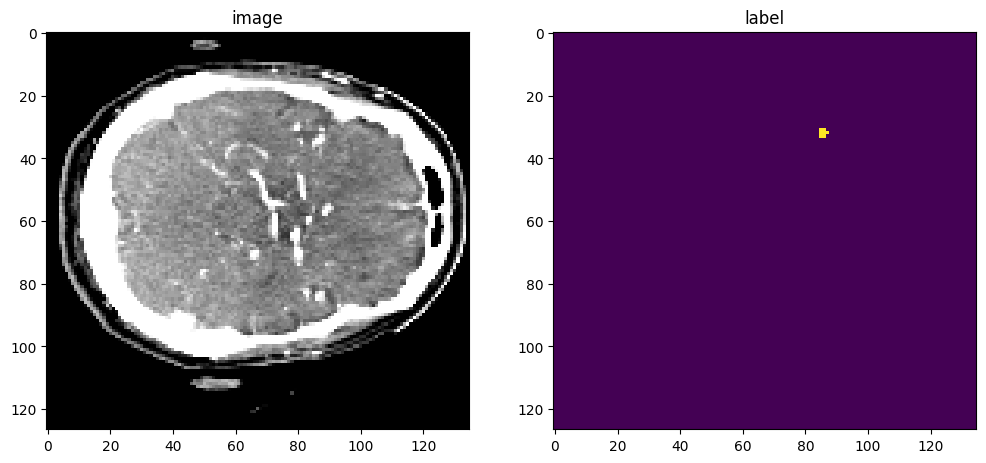

In [21]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)


image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the middle slice
# mid_slice = image.shape[2] // 2
mid_slice = 29
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, mid_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, mid_slice])
plt.show()


103


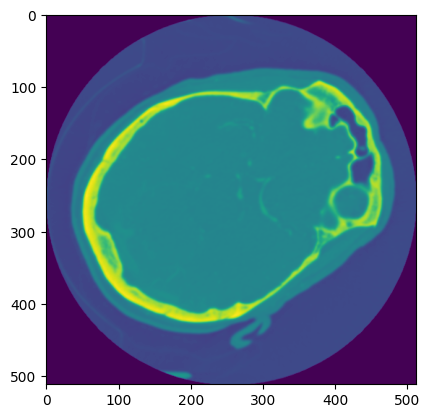

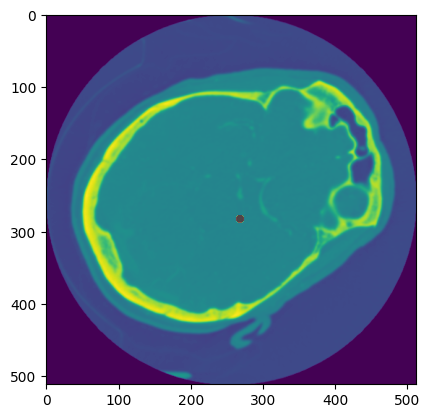

In [34]:
# Importing Required Libraries
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Function to Load a NIFTI File and Display a Slice
def load_nifti_file_and_display_slice(filepath, slice_index):
    nifti_file = nib.load(filepath)
    image_data = nifti_file.get_fdata()
    plt.imshow(image_data[:, :, slice_index], cmap="gray")
    plt.show()

# Function to Load a NIFTI File and Return as a NumPy Array
def load_nifti_file(filepath):
    nifti_file = nib.load(filepath)
    image_data = nifti_file.get_fdata()
    return image_data

# Set the Directory Path
train_data_directory = '/content/CODEC-IV/'

# Define the Paths to One Pair of Images for Testing
image_path = os.path.join(train_data_directory, 'sub-train005', 'sub-train005_MeanArterialPhase.nii')
annotation_path = os.path.join(train_data_directory, 'sub-train005', 'sub-train005_clot_annotation.nii.gz')

# Load and Display a Slice of the Image and Annotation

# load_nifti_file_and_display_slice(image_path, slide)
# load_nifti_file_and_display_slice(annotation_path, slide)

image_arr = nib.load(image_path).get_fdata()
annotation_arr = nib.load(annotation_path).get_fdata()


slice_index = int(np.where(annotation_arr.mean(axis=(0,1)) != 0)[0].mean()) # find middle point of segmentation
# slice_index = 136
print(slice_index)
plt.imshow(image_arr[:, :, slice_index], )
plt.show()
plt.imshow(image_arr[:, :, slice_index], )
plt.imshow(annotation_arr[:, :, slice_index], alpha=0.5*(annotation_arr[:, :, slice_index]>0), cmap="jet")



In [71]:
# check_ds = Dataset(data=val_files, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the slice [:, :, 80]
# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 80], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 80])
# plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [47]:
# train_files

In [22]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


In [23]:
# for i, img in enumerate(train_loader):
#   if i == 7:
#     # print(img['image'].shape)
#     preview_img = img['image'][0][0]
#     mid_slice = image.shape[2] // 2
#     plt.imshow(image[:, :, mid_slice], cmap="gray")
#     break

## Create Model, Loss, Optimizer

In [29]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

print("Done")

Done


## Execute a typical PyTorch training process

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

Streaming output truncated to the last 5000 lines.
38/49, train_loss: 0.5618
39/49, train_loss: 0.5615
40/49, train_loss: 0.5615
41/49, train_loss: 0.5612
42/49, train_loss: 0.5609
43/49, train_loss: 0.5608
44/49, train_loss: 0.5607
45/49, train_loss: 0.5603
46/49, train_loss: 0.5603
47/49, train_loss: 0.5598
48/49, train_loss: 0.5598
49/49, train_loss: 0.5595
epoch 6 average loss: 0.5643
saved new best metric model
current epoch: 6 current mean dice: 0.0001
best mean dice: 0.0001 at epoch: 6
----------
epoch 7/100
1/49, train_loss: 0.5600
2/49, train_loss: 0.5589
3/49, train_loss: 0.5590
4/49, train_loss: 0.5585
5/49, train_loss: 0.5588
6/49, train_loss: 0.5586
7/49, train_loss: 0.5582
8/49, train_loss: 0.5577
9/49, train_loss: 0.5575
10/49, train_loss: 0.5575
11/49, train_loss: 0.5575
12/49, train_loss: 0.5567
13/49, train_loss: 0.5568
14/49, train_loss: 0.5567
15/49, train_loss: 0.5562
16/49, train_loss: 0.5566
17/49, train_loss: 0.5561
18/49, train_loss: 0.5556
19/49, train_loss: 0

In [32]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0281 at epoch: 34


## Plot the loss and metric

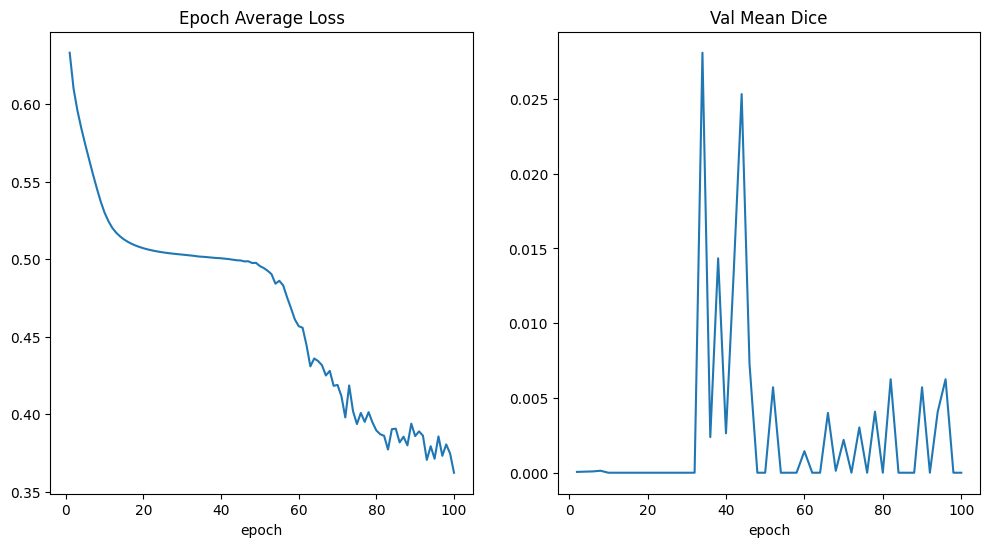

In [33]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

IndexError: ignored

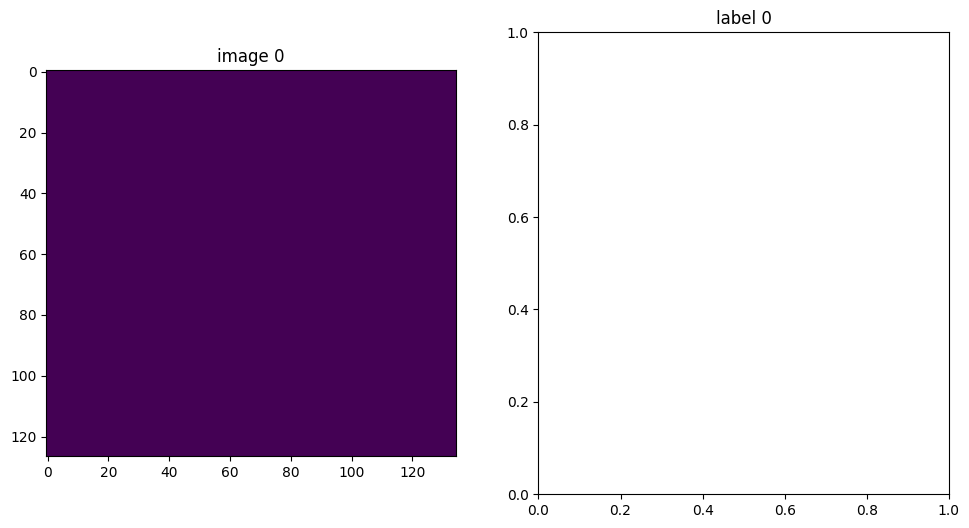

In [35]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["label"][0, 0, :, :, -1])
        # plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, -1])
        # plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Inference on Test Set

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)